In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# Define VAE model
class VAE(nn.Module):
    def __init__(self, x_dim: int = 28 * 28, k: int = 400, z_dim: int = 20) -> None:
        super().__init__()
        self.x_dim = x_dim
        self.k = k
        self.z_dim = z_dim

        # Define Encoder
        self.encoder = nn.Sequential(nn.Linear(self.x_dim, self.k), nn.ReLU())
        self.fc_mu = nn.Linear(self.k, self.z_dim)
        self.fc_logvar = nn.Linear(self.k, self.z_dim)

        # Define Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.z_dim, self.k),
            nn.ReLU(),
            nn.Linear(self.k, self.x_dim),
            nn.Sigmoid(),
        )

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        enc = self.encoder(x)
        mu = self.fc_mu(enc)
        logvar = self.fc_logvar(enc)

        return mu, logvar

    def reparametrise(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return mu + eps * std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)

    def forward(
        self, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x)
        z = self.reparametrise(mu, logvar)
        x_recon = self.decode(z)

        return x_recon, mu, logvar


def vae_loss(
    recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor
) -> torch.Tensor:
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [15]:
train_dataset = datasets.MNIST(
    root="./mnist_data/", train=True, transform=transforms.ToTensor(), download=True
)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = datasets.MNIST(
    root="./mnist_data/", train=False, transform=transforms.ToTensor(), download=True
)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define Model Object
vae = VAE(k=500,z_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 50
for e in range(epochs):
    vae.train()
    total_loss = 0

    for x, _ in train_dataloader:
        x = x.view(-1, 784)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {e + 1}, Loss: {total_loss / len(train_dataloader.dataset):.4f}")

    vae.eval()
    validation_loss = 0
    first=True
    for x, _ in test_dataloader:
        x = x.view(-1, 784)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        if first:
            print(f'{mu[0][0]:.4f} +/- {logvar[0][0]:.4f}')
            first=False
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        validation_loss += loss.item()

    print(f"Epoch {e + 1}, Validation Loss: {validation_loss / len(test_dataloader.dataset):.4f}")

Epoch 1, Loss: 189.0674
-2.8837 +/- -2.7636
Epoch 1, Validation Loss: 168.9058
Epoch 2, Loss: 166.1437
-3.1658 +/- -2.6813
Epoch 2, Validation Loss: 162.0265
Epoch 3, Loss: 160.6545
-3.4027 +/- -3.0564
Epoch 3, Validation Loss: 158.1172
Epoch 4, Loss: 157.5861
-3.2879 +/- -2.9423
Epoch 4, Validation Loss: 156.0277
Epoch 5, Loss: 155.8295
-3.4338 +/- -3.0188
Epoch 5, Validation Loss: 154.6830
Epoch 6, Loss: 154.5973
-3.1229 +/- -2.9328
Epoch 6, Validation Loss: 153.5995
Epoch 7, Loss: 153.5461
-3.1580 +/- -3.1602
Epoch 7, Validation Loss: 152.7587
Epoch 8, Loss: 152.8042
-3.0136 +/- -3.4686
Epoch 8, Validation Loss: 151.9865
Epoch 9, Loss: 152.1533
-2.9516 +/- -3.1922
Epoch 9, Validation Loss: 151.5564
Epoch 10, Loss: 151.5374
-3.0526 +/- -3.7644
Epoch 10, Validation Loss: 150.9096
Epoch 11, Loss: 150.9513
-2.9963 +/- -3.0529
Epoch 11, Validation Loss: 150.4603
Epoch 12, Loss: 150.4447
-3.1034 +/- -3.4800
Epoch 12, Validation Loss: 150.0838
Epoch 13, Loss: 150.0415
-3.0694 +/- -3.3791
E

# Testing Model

In [16]:
vae.eval()
for x, y in test_dataloader:
    x = x.view(-1, 784)
    x_recon, mu, logvar = vae(x)
    break

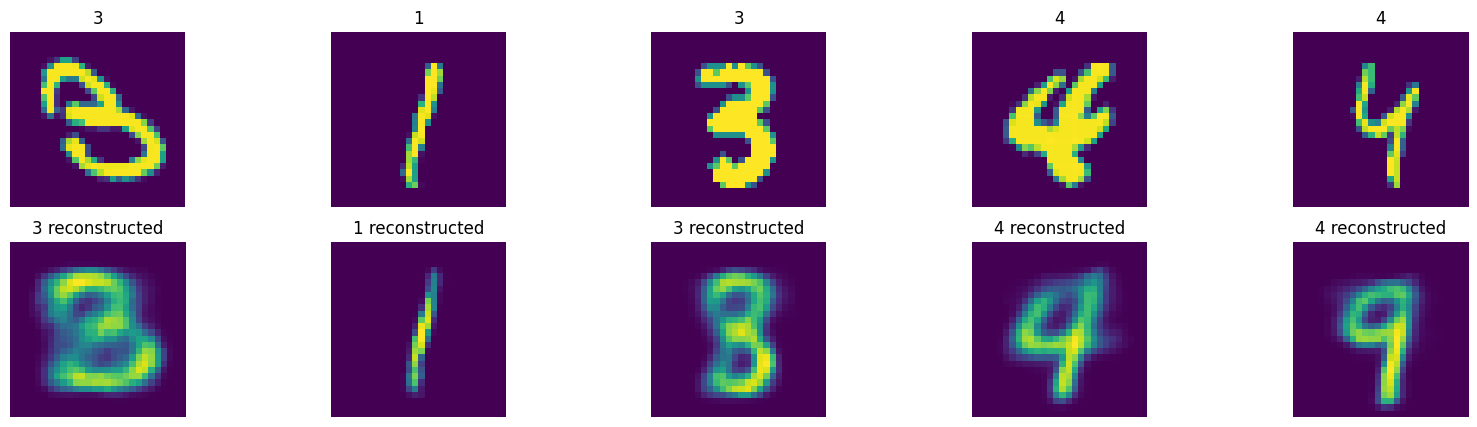

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 5))
for i in range(5):
    ind = np.random.randint(0, 128)
    plt.subplot(2, 5,i+1)
    plt.imshow(x[ind].numpy().reshape(28,28))
    plt.axis(False)
    plt.title(f'{y[ind]}')
    plt.subplot(2, 5,i+6)
    plt.imshow(x_recon[ind].detach().numpy().reshape(28,28))
    plt.axis(False)
    plt.title(f'{y[ind]} reconstructed')
plt.show()

# Visualising Latent Space

In [21]:
all_latent, all_sigma, all_latent_labels = [],[], []

for x, y in test_dataloader:
    x = x.view(-1, 784)
    all_latent += [vae.encode(x)[0]]
    all_sigma += [vae.encode(x)[1]]
    all_latent_labels += [y]

In [22]:
all_mu = torch.cat(all_latent, 0).detach().numpy()
all_sigma = torch.cat(all_sigma, 0).detach().numpy()
all_labels = torch.cat(all_latent_labels, 0).numpy()

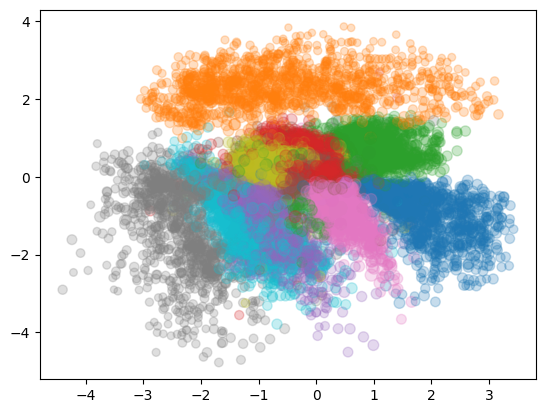

In [48]:
plt.figure()
plt.scatter(
    all_mu[:, 0], all_mu[:, 1], c = all_labels, cmap='tab10', alpha=0.25, s = (all_sigma[:, 0]**2 + all_sigma[:, 1]**2)
)
plt.show()

In [35]:
all_sigma[:, 0]

array([-3.271951 , -5.0375547, -4.3362374, ..., -5.4440365, -6.5244284,
       -7.4081726], shape=(10000,), dtype=float32)

# Convolutional VAE

In [177]:
class ConvVAE(nn.Module):
    def __init__(self, z_dim: int = 20):
        super().__init__()
        self.z_dim = z_dim

        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),   # 28→14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),  # 14→7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # 7→4
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),# 4→2
            nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            h = self.encoder(dummy)
            self.flat_dim = h.shape[1]   # should be 1024

        # Latent projection
        self.fc_mu = nn.Linear(self.flat_dim, z_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, z_dim)

        # ----- Decoder -----
        self.fc_decode = nn.Linear(z_dim, self.flat_dim)

        self.decoder = nn.Sequential(
            # 2 → 4
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),

            # 4 → 7  (special layer!)
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=0),
            nn.ReLU(),

            # 7 → 14
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),

            # 14 → 28
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparametrise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(z.size(0), 256, 2, 2)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrise(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [187]:
train_dataset = datasets.MNIST(
    root="./mnist_data/", train=True, transform=transforms.ToTensor(), download=True
)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = datasets.MNIST(
    root="./mnist_data/", train=False, transform=transforms.ToTensor(), download=True
)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define Model Object
vae = ConvVAE(z_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 50
for e in range(epochs):
    vae.train()
    total_loss = 0

    for x, _ in train_dataloader:
        # x = x.view(-1, 784)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {e + 1}, Loss: {total_loss / len(train_dataloader.dataset):.4f}")

    vae.eval()
    validation_loss = 0
    first=True
    for x, _ in test_dataloader:
        # x = x.view(-1, 784)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        if first:
            print(f'{mu[0][0]:.4f} +/- {logvar[0][0]:.4f}')
            first=False
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        validation_loss += loss.item()

    print(f"Epoch {e + 1}, Validation Loss: {validation_loss / len(test_dataloader.dataset):.4f}")

Epoch 1, Loss: 181.0519
1.4839 +/- -4.1455
Epoch 1, Validation Loss: 162.0837
Epoch 2, Loss: 156.1782
1.1572 +/- -4.5301
Epoch 2, Validation Loss: 154.9567
Epoch 3, Loss: 151.9465
1.5733 +/- -4.4243
Epoch 3, Validation Loss: 152.0086
Epoch 4, Loss: 149.3303
1.5225 +/- -4.6611
Epoch 4, Validation Loss: 149.7899
Epoch 5, Loss: 147.6222
1.7037 +/- -4.4132
Epoch 5, Validation Loss: 148.0892
Epoch 6, Loss: 146.3638
1.6440 +/- -4.7202
Epoch 6, Validation Loss: 147.1737
Epoch 7, Loss: 145.2890
1.5701 +/- -4.8896
Epoch 7, Validation Loss: 146.0115
Epoch 8, Loss: 144.3774
1.6822 +/- -5.1443
Epoch 8, Validation Loss: 145.3841
Epoch 9, Loss: 143.8135
1.7919 +/- -4.9931
Epoch 9, Validation Loss: 144.8957
Epoch 10, Loss: 143.0750
1.6778 +/- -5.2027
Epoch 10, Validation Loss: 143.9067
Epoch 11, Loss: 142.5088
1.5591 +/- -5.2444
Epoch 11, Validation Loss: 143.0264
Epoch 12, Loss: 142.1635
1.4423 +/- -4.9216
Epoch 12, Validation Loss: 142.6024
Epoch 13, Loss: 141.5534
1.5259 +/- -5.3038
Epoch 13, Vali

KeyboardInterrupt: 

In [189]:
vae.eval()
for x, y in test_dataloader:
    # x = x.view(-1, 784)
    x_recon, mu, logvar = vae(x)
    break

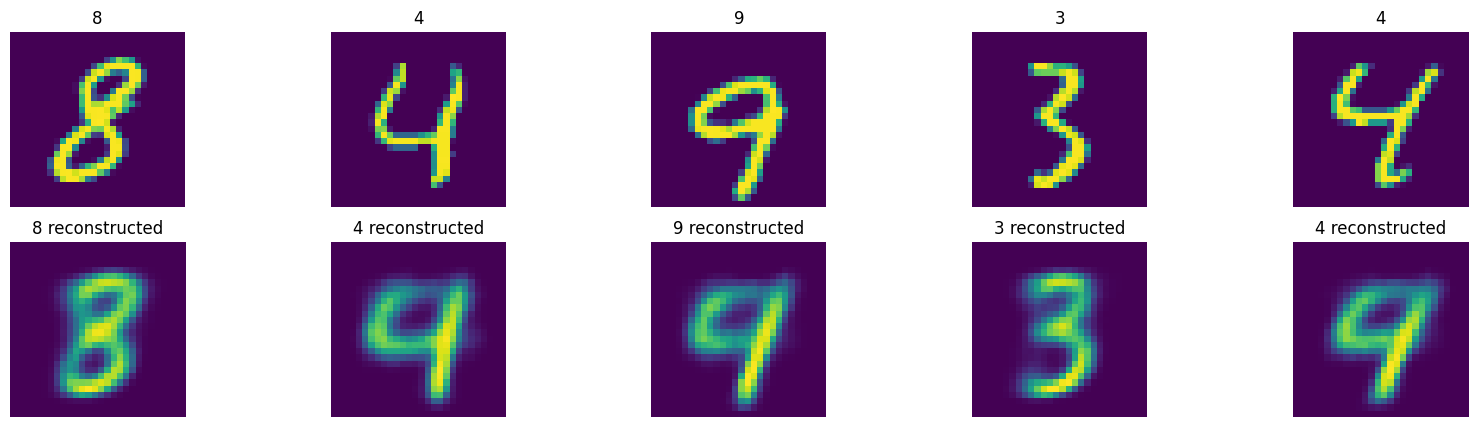

In [203]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 5))
for i in range(5):
    ind = np.random.randint(0, 128)
    plt.subplot(2, 5,i+1)
    plt.imshow(x[ind].numpy().reshape(28,28))
    plt.axis(False)
    plt.title(f'{y[ind]}')
    plt.subplot(2, 5,i+6)
    plt.imshow(x_recon[ind].detach().numpy().reshape(28,28))
    plt.axis(False)
    plt.title(f'{y[ind]} reconstructed')
plt.show()